# train NDE to estimate community distribution $p(X) \approx \mathcal{Q}_\phi(X)$
$\mathcal{Q}_\phi(X)$ will be used check for support

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
from noah2 import data as D
from noah2 import util as U

In [3]:
import copy
import torch
from nflows import transforms, distributions, flows
from torch import optim

In [4]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [5]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

## load train/valid/test dataset

In [6]:
DNoah = D.Noah2()
fema = DNoah.data[:,1:]

In [7]:
if not os.path.isdir('../dat/nde_support'): 
    os.system('mkdir -p ../dat/nde_support')

In [8]:
ftrain = '../dat/nde_support/data.train.npy'
fvalid = '../dat/nde_support/data.valid.npy'
ftest  = '../dat/nde_support/data.test.npy'

if ~(os.path.isfile(ftrain) and os.path.isfile(fvalid) and os.path.isfile(ftest)): 

    Ntrain = int(0.8 * len(fema))
    Nvalid = int(0.1 * len(fema))
    Ntest = len(fema) - Ntrain - Nvalid
    

    irandom = np.arange(len(fema))
    np.random.shuffle(irandom)
    
    x_train = fema[irandom][:Ntrain]
    x_valid = fema[irandom][Ntrain:Ntrain+Nvalid]
    x_test = fema[irandom][Ntrain+Nvalid:]
    
    # log10 for income and population 
    x_train[:,2] = np.log10(x_train[:,2])
    x_train[:,3] = np.log10(x_train[:,3])
    x_valid[:,2] = np.log10(x_valid[:,2])
    x_valid[:,3] = np.log10(x_valid[:,3])
    x_test[:,2] = np.log10(x_test[:,2])
    x_test[:,3] = np.log10(x_test[:,3])    
    
    np.save(ftrain, x_train[np.all(np.isfinite(x_train), axis=1)])
    np.save(fvalid, x_valid[np.all(np.isfinite(x_valid), axis=1)])
    np.save(ftest, x_test[np.all(np.isfinite(x_test), axis=1)])
else: 
    x_train = np.load(ftrain)
    x_valid = np.load(fvalid)    
    x_test = np.load(ftest)
    
    Ntrain = x_train.shape[0]
    Nvalid = x_valid.shape[0]
    Ntest = x_test.shape[0]
print('Ntrain = %i, Nvalid = %i, Ntest = %i' % (Ntrain, Nvalid, Ntest))

Ntrain = 158204, Nvalid = 19775, Ntest = 19777


In [9]:
ndim = x_train.shape[1]
print('%i dimensions' % ndim)

26 dimensions


## cdf transformation of the data
The data here have hard ranges. Lets relax this by implementing a CDF transformation

In [10]:
bounds = [
    [-1e-3, 2000.], # mean rainfall
    [0., 10.],   # flood risk score
    [np.log10(1e4), np.log10(2.5e5)], # log10(median household income)
    [np.log10(10), np.log10(2e5)], # log10(population)
    [-1e-3, 1.+1e-3], # renter fraction
    [-1e-3, 1.+1e-3], # education fraction
    [-1e-3, 1.+1e-3] # white fraction
]

for activity in ['s_c310', 's_c320', 's_c330', 's_c340', 's_c350', 's_c360', 's_c370', 
                 's_c410', 's_c420', 's_c430', 's_c440', 's_c450', 
                 's_c510', 's_c520', 's_c530', 's_c540',
                 's_c610', 's_c620', 's_c630']: 
    bounds.append([-1e-3, 100.+1e-3])

In [11]:
cx_train = np.empty(x_train.shape)
cx_valid = np.empty(x_valid.shape)
cx_test = np.empty(x_test.shape)

for i in range(ndim): 
    cx_train[:,i] = U.inv_cdf_transform(x_train[:,i], bounds[i])
    cx_valid[:,i] = U.inv_cdf_transform(x_valid[:,i], bounds[i])
    cx_test[:,i] = U.inv_cdf_transform(x_test[:,i], bounds[i])    

In [20]:
np.save('../dat/nde_support/data.train.inv_cdf.npy', cx_train)
np.save('../dat/nde_support/data.valid.inv_cdf.npy', cx_valid)
np.save('../dat/nde_support/data.test.inv_cdf.npy', cx_test)

In [12]:
train_loader = torch.utils.data.DataLoader(torch.tensor(cx_train.astype(np.float32)).to(device), batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(torch.tensor(cx_valid.astype(np.float32)).to(device), batch_size=512, shuffle=False)

## train $\mathcal{Q}_\phi(X)$

In [13]:
def init_flow(nhidden, nblocks): 
    ''' initialize flow with input architecture and standard normal base distribution 
    '''
    blocks = []
    for iblock in range(nblocks): 
        blocks += [transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
                transforms.RandomPermutation(features=ndim)]
    transform = transforms.CompositeTransform(blocks)

    base_distribution = distributions.StandardNormal(shape=[ndim])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    return flow

203x9
Epoch: 0 LR 1.00e-03 TRAINING Loss: 3.76e+01 VALIDATION Loss: 2.61e+01
Epoch: 10 LR 1.00e-03 TRAINING Loss: -1.36e+01 VALIDATION Loss: -1.39e+01
Epoch: 20 LR 1.00e-03 TRAINING Loss: -4.24e+00 VALIDATION Loss: -1.07e+01
Epoch: 30 LR 1.00e-03 TRAINING Loss: -3.27e+01 VALIDATION Loss: -3.55e+01
Epoch: 40 LR 1.00e-03 TRAINING Loss: -5.44e+01 VALIDATION Loss: -6.03e+01
Epoch: 50 LR 1.00e-03 TRAINING Loss: -7.00e+01 VALIDATION Loss: -7.20e+01
Epoch: 60 LR 1.00e-03 TRAINING Loss: -5.62e+01 VALIDATION Loss: -5.71e+01
Epoch: 70 LR 1.00e-03 TRAINING Loss: -6.76e+01 VALIDATION Loss: -6.78e+01


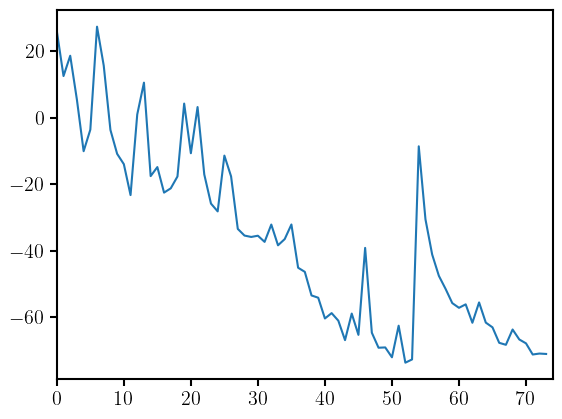

490x13


/tmp/ipykernel_3459871/2849686447.py:55: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, len(valid_losses))


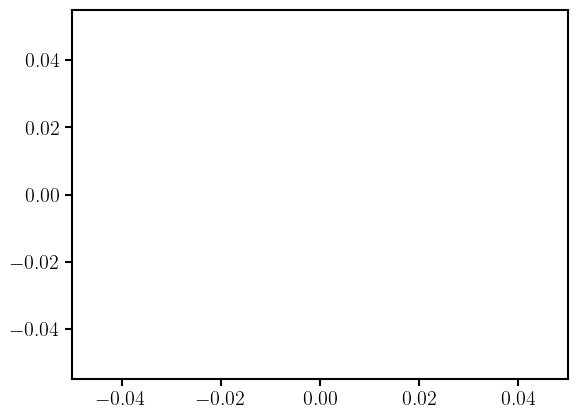

304x6
Epoch: 0 LR 1.00e-03 TRAINING Loss: 1.58e+01 VALIDATION Loss: -7.06e-02


In [ ]:
num_iter = 1000
patience = 20
lrate    = 1e-3

all_flows, all_archs, all_valid_losses = [], [], []
for i in range(5): 
    # randomly sample architecture
    nhidden = int(np.ceil(np.random.uniform(64, 512)))
    nblocks = int(np.random.uniform(3, 15))
    print('%ix%i' % (nhidden, nblocks))
    
    flow = init_flow(nhidden, nblocks) 
    flow.to(device)

    optimizer = optim.Adam(flow.parameters(), lr=lrate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, min_lr=1e-5)
    #optim.lr_scheduler.OneCycleLR(optimizer, lrate, total_steps=num_iter)

    best_epoch, best_valid_loss, valid_losses = 0, np.inf, []
    for epoch in range(num_iter):
        # train 
        train_loss = 0.
        for batch in train_loader: 
            optimizer.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss = train_loss/float(len(train_loader))
    
        # validate
        with torch.no_grad():
            valid_loss = 0.
            for batch in valid_loader: 
                loss = -flow.log_prob(batch).mean()
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_loader)
            if np.isnan(valid_loss): break
            valid_losses.append(valid_loss)
        scheduler.step(valid_loss)

        if epoch % 10 == 0: 
            print('Epoch: %i LR %.2e TRAINING Loss: %.2e VALIDATION Loss: %.2e' % 
                          (epoch, scheduler._last_lr[0], train_loss, valid_loss))
            
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_epoch = epoch
            best_flow = copy.deepcopy(flow)
        else: 
            if epoch > best_epoch + patience: 
                break 

    plt.plot(np.arange(len(valid_losses)), valid_losses)
    plt.xlim(0, len(valid_losses))
    plt.show()
    
    all_archs.append('%ix%i' % (nhidden, nblocks))
    all_flows.append(best_flow)
    all_valid_losses.append(valid_losses)